In [17]:
import pandas as pd

main_data=pd.read_csv("../Data/QQQ_MarketRisk.csv")
main_data.head()

,Date,QQQ_Return,QQQ_Realized_Volatility,QQQ_Volume,VIX,RSI_14,VXN,FedRate
0,2018-02-22,-0.000121,0.283918,37074400,18.719999,45.694866,20.910000,1.605
1,2018-02-23,0.020449,0.292777,50096900,16.490000,54.847444,18.160000,1.605
2,2018-02-26,0.013260,0.296290,39266700,15.800000,68.915674,18.120001,1.608
3,2018-02-27,-0.012383,0.294652,42209900,18.590000,59.841920,20.490000,1.635
4,2018-02-28,-0.006417,0.294987,42936300,19.850000,61.921096,22.010000,1.618


1. Test for stationarity: ADF test 

In [18]:
from statsmodels.tsa.stattools import adfuller


result = adfuller(main_data["QQQ_Return"]) 
print('p-value:', result[1])

p-value: 7.243407513311069e-25


2. Testing for ARCH Effects

In [19]:
from statsmodels.stats.diagnostic import het_arch
lag_order = 10 
arch_test = het_arch(main_data["QQQ_Return"], maxlag=lag_order)
print('p-value:', arch_test[1])  

p-value: 1.2149365544983e-100


/var/folders/76/jd772b6x14q309k0qnxn4k0r0000gq/T/ipykernel_84416/3726756681.py:3: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(main_data["QQQ_Return"], maxlag=lag_order)


3. basic GARCH(1,1)

In [20]:
from arch import arch_model
model = arch_model(main_data["QQQ_Return"], vol='Garch', p=1, q=1)  # GARCH(1,1)
result = model.fit(update_freq=5, disp='on')

forecasts = result.forecast(horizon=1)
predicted_volatility = forecasts.variance.iloc[-1] ** 0.5

predicted_volatility


/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


h.1    0.013119
Name: 1724, dtype: float64

### test

In [30]:
import numpy as np

main_data = main_data.sort_values("Date")

# Calculate split index
train_size = int(len(main_data) * 0.8)

# 80% train
train_set = main_data.iloc[:train_size]

# 20% test
test_set = main_data.iloc[train_size:]


model = arch_model(main_data["QQQ_Return"], vol='Garch', p=1, q=1)  # GARCH(1,1)
result = model.fit(update_freq=5, disp='on')

predicted_vols = []

# Start from just after the training period
for i in range(len(test_set)):
    # Combine training set with test set up to day i
    end_idx = len(train_set) + i
    sub_data = main_data["QQQ_Return"].iloc[:end_idx]

    model = arch_model(sub_data, vol='Garch', p=1, q=1)
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)
    
    # Take the predicted variance for the next day
    pred_var = forecast.variance['h.1'].iloc[-1]
    predicted_vols.append(np.sqrt(pred_var))



/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/CynthiaSY/miniforge3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002589. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/CynthiaSY/miniforge3/lib/python3.12/site-

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

predicted_vol_series = pd.Series(predicted_vols, index=test_set.index)

predicted_vol_series_ann = predicted_vol_series * np.sqrt(252)

y_true = test_set["QQQ_Realized_Volatility"]     
y_pred = predicted_vol_series_ann               

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# R-squared (Coefficient of Determination)
r2 = r2_score(y_true, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.4f}")



Mean Squared Error (MSE): 0.000672
Root Mean Squared Error (RMSE): 0.025929
Mean Absolute Error (MAE): 0.021634
R-squared (R²): 0.6295


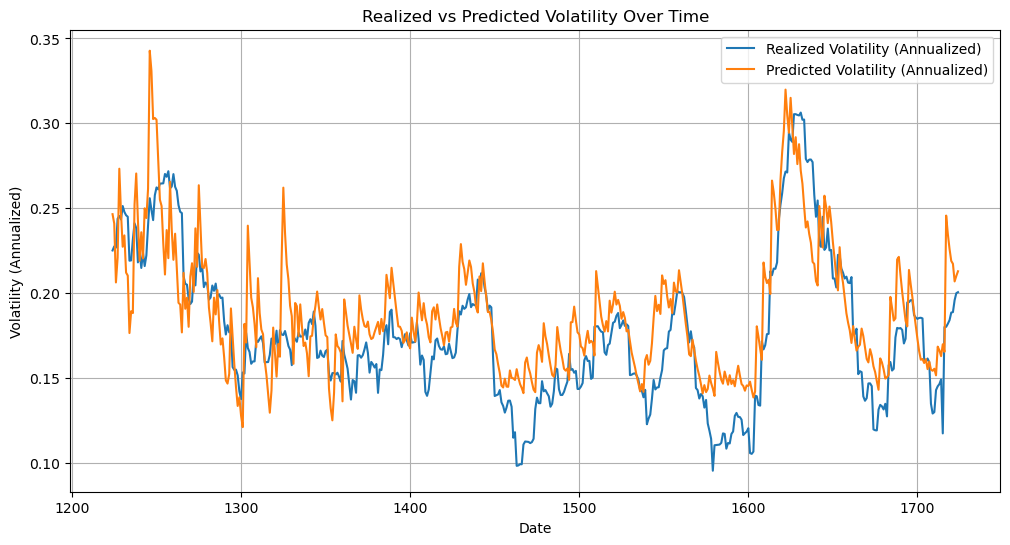

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_true.index, y_true, label="Realized Volatility (Annualized)")
plt.plot(y_pred.index, y_pred, label="Predicted Volatility (Annualized)")
plt.legend()
plt.title("Realized vs Predicted Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility (Annualized)")
plt.grid(True)
plt.show()
